In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-plrpqmdx
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-plrpqmdx
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1087771 sha256=6182e6088b27e3a04bb652bcd876cf9ebe54bbb0ecb28bfa38d30d688e38ca73
  Stored in directory: /tmp/pip-ephem-wheel-cache-b6o0uj2w/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import os
import h5py
import fitsio
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1
from bgs_sv import obscond

In [3]:
fsky = 'sv1.all_exps.20210303.Isky.npy'
fwave = 'sv1.all_exps.20210303.wave.npy'
fobscond = 'sv1.all_exps.20210303.obs_cond.hdf5'

sv1_exps = atable.Table.read(fobscond, format='hdf5')
sv1_skies = np.load(fsky)
sv1_wave = np.load(fwave)

In [4]:
gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210228.fits')

In [5]:
ra, dec = [], [] 
for i in range(len(sv1_exps)): 
    isexp = gfa['EXPID'] == sv1_exps['EXPID'][i]
    ra.append(np.median(gfa['SKYRA'][isexp]))
    dec.append(np.median(gfa['SKYDEC'][isexp]))
sv1_exps['SKYRA'] = np.array(ra)
sv1_exps['SKYDEC'] = np.array(dec)

In [6]:
# get sun conditions 
sun_ra, sun_dec, sun_alt = [], [], []
for mjd in sv1_exps['MJD']: 
    _sun_ra, _sun_dec, _sun_alt = obscond.get_sun(mjd)
    sun_ra.append(_sun_ra)
    sun_dec.append(_sun_dec)
    sun_alt.append(_sun_alt)
sun_ra = np.array(sun_ra)
sun_dec = np.array(sun_dec)
sun_alt = np.array(sun_alt)

In [7]:
# calculate sun separation
sun_sep = obscond.ang_separation(np.array(sv1_exps['SKYRA']), np.array(sv1_exps['SKYDEC']), sun_ra, sun_dec)

In [8]:
sv1_twilight = (sv1_exps['TRANSPARENCY'] > 0.95) & (sun_alt > -18)
sv1_twilight_exps = sv1_exps[sv1_twilight]
print('%i twilight exposures with TRANSP > 0.95' % len(sv1_twilight_exps))

39 twilight exposures with TRANSP > 0.95


In [9]:
# observing conditions from median value of the GFAs
sv1_airmass = sv1_twilight_exps['AIRMASS']
sv1_moon_frac = sv1_twilight_exps['MOON_ILLUMINATION']
sv1_moon_sep = sv1_twilight_exps['MOON_SEP_DEG']
sv1_moon_alt = 90. - sv1_twilight_exps['MOON_ZD_DEG']
sv1_sun_alt = sun_alt[sv1_twilight]
sv1_sun_sep = sun_sep[sv1_twilight]
sv1_Iskies = sv1_skies[sv1_twilight]

In [10]:
dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    boss_fiber_area = np.pi

    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [11]:
boss_skies = read_BOSS_skies()

# get exposures where sun_alt > -18 to estimate twilight contribution
twilight = boss_skies['sun_alt'] > -18.
print('%i of %i BOSS exposures have sun altitude > -18.' % (np.sum(twilight), len(boss_skies['sun_alt'])))

for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][twilight]

154 of 1144 BOSS exposures have sun altitude > -18.


(-20.0, -12.0)

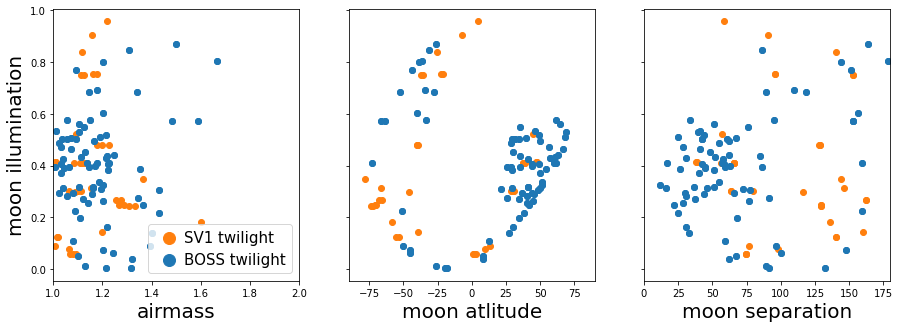

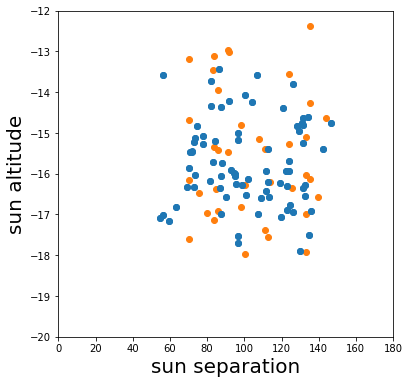

In [12]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(sv1_airmass, sv1_moon_frac, c='C1', label='SV1 twilight')
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS twilight')
sub.legend(loc='lower right', frameon=True, handletextpad=0, markerscale=2, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(sv1_moon_alt, sv1_moon_frac, c='C1')
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')

sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(sv1_moon_sep, sv1_moon_frac, c='C1')
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')

sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])


fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(sv1_sun_sep, sv1_sun_alt, c='C1')
sub.scatter(boss_skies['sun_sep'], boss_skies['sun_alt'], c='C0', label='BOSS')

sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim(-20., -12.)

In [13]:
from itertools import chain, combinations_with_replacement
def Isky5000A_model_notwilight(airmass, moon_frac, moon_alt, moon_sep):
    ''' third degree polynomial regression sky model
    '''
    norder = 5 
    skymodel_coeff = np.array([ 1.19728287e-02,  2.68146174e-02,  2.78840941e-02,  4.41723544e-03,
       -1.02111676e-01,  7.65110151e-03,  1.63878220e-02, -3.08958375e-02,
        3.85657345e-01,  6.83474920e-03,  3.06045766e-01,  2.55798622e-01,
        1.19306254e-03, -1.04242412e-02, -3.34780689e-03, -1.68835833e-02,
        1.11378109e-02, -1.75611187e-01, -2.38751513e-01,  1.46593863e-02,
       -4.36980545e-02, -1.78128533e-01,  5.85014404e-03,  1.37745149e-02,
       -1.81392009e-03, -1.27115538e-02,  9.35953790e-02, -1.52422946e-01,
       -1.74469624e-04, -6.01814594e-03, -2.13820870e-04, -7.40115962e-05,
       -4.43960687e-05,  1.31544250e-04,  5.23119315e-05, -3.07378710e-02,
        3.50689477e-02,  1.85015093e-01,  6.13788213e-02,  1.98622649e-02,
       -7.03566704e-02, -2.70010457e-01, -4.13256930e-03, -4.65235557e-03,
        2.08199644e-03,  4.06645589e-03,  2.08415057e-01,  4.87587825e-01,
       -7.34996335e-03,  1.37774943e-03,  6.26446800e-03,  2.14264776e-05,
       -1.34520777e-05, -1.28680576e-04, -2.98020923e-05,  1.41853618e-03,
       -2.22111586e-01, -5.77624465e-01, -1.09989601e-02, -2.77969195e-04,
        2.17332386e-03,  1.47785979e-04,  1.63001051e-04,  3.10888811e-05,
       -5.98993375e-05, -8.54879999e-08,  3.29709501e-07,  2.92447174e-08,
       -2.79763418e-07, -2.38343236e-08, -1.10769335e-01,  8.24805309e-02,
       -2.67759016e-02, -1.09365333e-03,  9.87385635e-03,  3.12620536e-02,
        9.15874867e-02, -2.52374361e-05, -4.92100655e-04, -4.21467759e-04,
        5.28695530e-03,  1.93471362e-01, -5.37647583e-02, -4.34387094e-04,
       -2.25656833e-03, -7.15039182e-04,  1.18896366e-05,  2.77215519e-05,
        2.81214300e-05, -2.48811976e-06,  1.29700918e-02, -1.92447646e-02,
       -2.44212957e-01, -5.99603226e-03, -2.76089664e-03,  9.14612070e-04,
        6.91296852e-05,  1.02360578e-04,  1.16371717e-05, -2.52971480e-05,
       -1.37227312e-07, -3.75516901e-07,  5.48164999e-08,  5.06994020e-07,
        1.93984829e-07,  5.32931890e-02,  5.79701139e-01,  4.34770814e-01,
       -6.79348983e-03, -1.31426633e-02, -6.14432600e-05,  1.39891173e-04,
        3.29198340e-04,  1.11812563e-04, -1.17664897e-05, -1.29847018e-06,
       -3.91089212e-06, -2.85449951e-06, -3.27679136e-07,  3.48519396e-07,
        3.29795490e-09,  7.65512533e-09,  6.37102357e-09,  5.95568585e-10,
       -2.63641980e-09, -1.30434882e-09])
    
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_alt, moon_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, norder+1))
    theta_transform = np.empty((theta.shape[0], len(skymodel_coeff)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.exp(np.dot(theta_transform, skymodel_coeff.T))
    #return np.clip(np.dot(theta_transform, skymodel_coeff.T), 1.1282850428182252, None)

In [14]:
# get model sky brightness at 5000A from dark sky + scattered moon light (excluding twilight)
model_Iskies5000_sv1 = Isky5000A_model_notwilight(sv1_airmass, sv1_moon_frac, sv1_moon_alt, sv1_moon_sep)
model_Iskies5000_boss = Isky5000A_model_notwilight(boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_alt'], boss_skies['moon_sep'])

In [15]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing)

In [16]:
# sky brightness for SV1
sv1_Iskies5000 = []
for Isky in sv1_Iskies: 
    Ismooth = smooth_sky(Isky, smoothing=100) # BOSS has 8x smaller binning
    sv1_Iskies5000.append(np.interp(5000, sv1_wave, Ismooth))
    
# sky brightness for BOSS
boss_Iskies5000 = []
for _w, Isky in zip(boss_skies['wave_b'], boss_skies['sky_b']): 
    Ismooth = smooth_sky(Isky, smoothing=800) # BOSS has 8x smaller binning
    boss_Iskies5000.append(np.interp(5000, _w, Ismooth))

(0.0, 12.0)

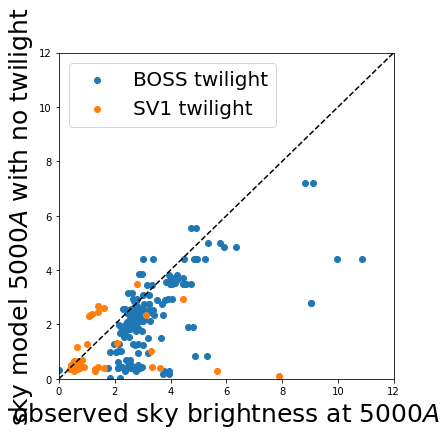

In [17]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(boss_Iskies5000, model_Iskies5000_boss, c='C0', label='BOSS twilight')
sub.scatter(sv1_Iskies5000, model_Iskies5000_sv1, c='C1', label='SV1 twilight')
sub.plot([0., 12.], [0., 12.], c='k', ls='--')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('observed sky brightness at $5000A$', fontsize=25)
sub.set_xlim(0., 12)
sub.set_ylabel('sky model $5000A$ with no twilight', fontsize=25)
sub.set_ylim(0., 12)

In [18]:
sv1_Iskies_twilight = sv1_Iskies5000 - model_Iskies5000_sv1
boss_Iskies_twilight = boss_Iskies5000 - model_Iskies5000_boss

(-2.0, 8.0)

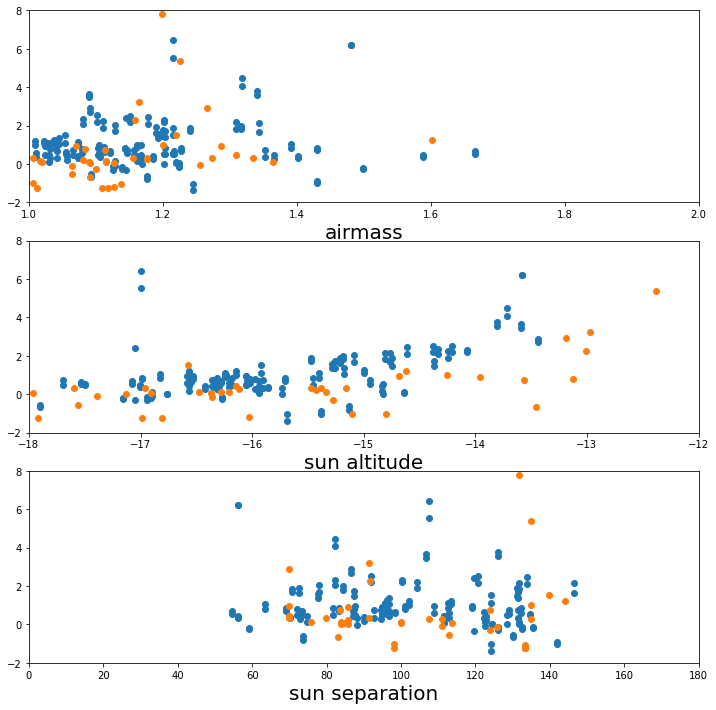

In [19]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(311)
sub.scatter(boss_skies['airmass'], boss_Iskies_twilight)
sub.scatter(sv1_airmass, sv1_Iskies_twilight)

sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylim(-2, 8)

sub = fig.add_subplot(312)
sub.scatter(boss_skies['sun_alt'], boss_Iskies_twilight)
sub.scatter(sv1_sun_alt, sv1_Iskies_twilight)

sub.set_xlabel('sun altitude', fontsize=20)
sub.set_xlim(-18, -12)
sub.set_ylim(-2, 8)

sub = fig.add_subplot(313)
sub.scatter(boss_skies['sun_sep'], boss_Iskies_twilight)
sub.scatter(sv1_sun_sep, sv1_Iskies_twilight)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylim(-2, 8)

In [20]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import chain, combinations_with_replacement

In [21]:
theta_train = np.vstack([
    np.concatenate([sv1_airmass, boss_skies['airmass']]), 
    np.concatenate([sv1_sun_alt, boss_skies['sun_alt']]), 
    np.concatenate([sv1_sun_sep, boss_skies['sun_sep']])]).T
Isky_train = np.concatenate([sv1_Iskies_twilight, boss_Iskies_twilight])

theta_train = theta_train[Isky_train > 0]
Isky_train = Isky_train[Isky_train > 0]

regmodels_fsky, scores = [], [] 
for n_order in range(1, 5): 
    # we use Ridge instead of LinearRegression to regularize the coefficients
    regress_fsky = Pipeline([('poly', PolynomialFeatures(n_order)),
                             ('linear', Ridge(alpha=1., fit_intercept=False))]) 
    regress_fsky.fit(theta_train, Isky_train)
    regmodels_fsky.append(regress_fsky)
    
    # evaluate the model using crossvalidation
    _scores = cross_val_score(regress_fsky, theta_train, Isky_train, scoring="neg_mean_squared_error")
    #_scores = [-np.sum((Isky_train - regress_fsky.predict(theta_train))**2)]
    
    print('%i order: score=%f' % (n_order, -np.mean(_scores)))
    scores.append(-np.mean(_scores))
norder = np.argmin(scores)+1
regress_fsky = regmodels_fsky[np.argmin(scores)]


1 order: score=1.365907
2 order: score=1.698489
3 order: score=2.424435
4 order: score=8.253941


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.24726e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53558e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.52215e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.8252e-19): result may not b

In [22]:
steps = regress_fsky.get_params()
skymodel_coeff = steps['linear'].coef_
skymodel_intercept = steps['linear'].intercept_

In [23]:
print(norder)

1


In [24]:
skymodel_coeff

array([3.50300842, 2.63453598, 0.40491282, 0.0096106 ])

In [25]:
def skymodel_twi(airmass, sun_alt, sun_sep):
    ''' 
    '''
    theta = np.atleast_2d(np.array([airmass, sun_alt, sun_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(3), i) for i in range(0, norder+1))
    theta_transform = np.empty((theta.shape[0], len(skymodel_coeff)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.clip(np.dot(theta_transform, skymodel_coeff.T) + skymodel_intercept, 0, None)

In [26]:
Isky5000_twilight_reg = skymodel_twi(
    np.concatenate([sv1_airmass, boss_skies['airmass']]), 
    np.concatenate([sv1_sun_alt, boss_skies['sun_alt']]), 
    np.concatenate([sv1_sun_sep, boss_skies['sun_sep']]))

(0.0, 6.0)

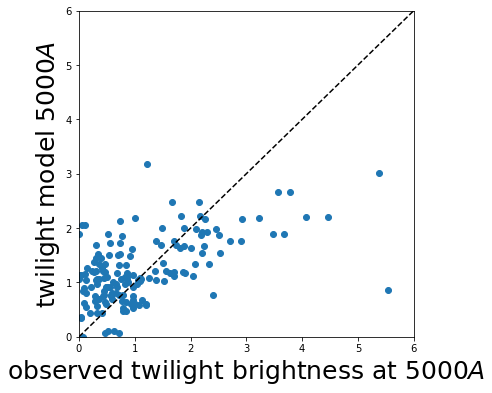

In [27]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(np.concatenate([sv1_Iskies_twilight, boss_Iskies_twilight]), Isky5000_twilight_reg)
sub.plot([0., 12.], [0., 12.], c='k', ls='--')
sub.set_xlabel('observed twilight brightness at $5000A$', fontsize=25)
sub.set_xlim(0., 6)
sub.set_ylabel('twilight model $5000A$', fontsize=25)
sub.set_ylim(0., 6)

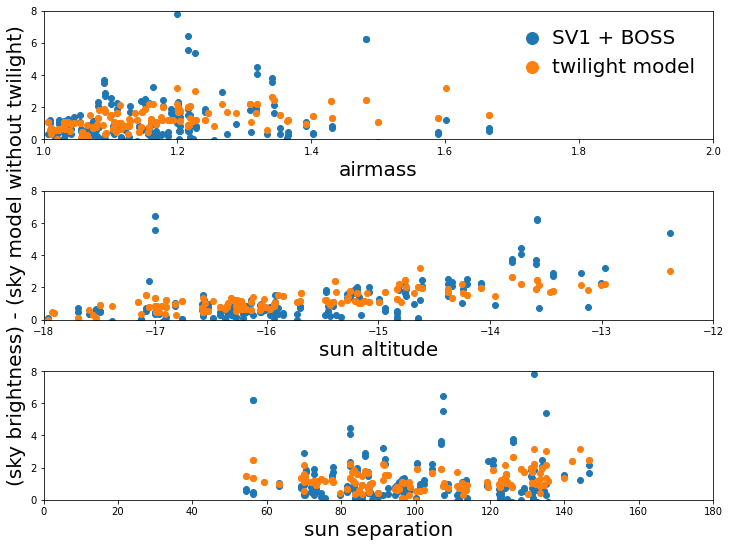

In [28]:
fig = plt.figure(figsize=(12,9))
sub = fig.add_subplot(311)
sub.scatter(np.concatenate([sv1_airmass, boss_skies['airmass']]), np.concatenate([sv1_Iskies_twilight, boss_Iskies_twilight]), label='SV1 + BOSS')
sub.scatter(np.concatenate([sv1_airmass, boss_skies['airmass']]), Isky5000_twilight_reg, label='twilight model')
sub.legend(loc='upper right', fontsize=20, handletextpad=0, markerscale=2, frameon=False)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylim(0., 8)

sub = fig.add_subplot(312)
sub.scatter(np.concatenate([sv1_sun_alt, boss_skies['sun_alt']]), np.concatenate([sv1_Iskies_twilight, boss_Iskies_twilight]))
sub.scatter(np.concatenate([sv1_sun_alt, boss_skies['sun_alt']]), Isky5000_twilight_reg)

sub.set_xlabel('sun altitude', fontsize=20)
sub.set_xlim(-18, -12)
sub.set_ylabel('(sky brightness) - (sky model without twilight)', fontsize=20)
sub.set_ylim(0., 8)

sub = fig.add_subplot(313)
sub.scatter(np.concatenate([sv1_sun_sep, boss_skies['sun_sep']]), np.concatenate([sv1_Iskies_twilight, boss_Iskies_twilight]))
sub.scatter(np.concatenate([sv1_sun_sep, boss_skies['sun_sep']]), Isky5000_twilight_reg)

sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylim(0., 8)
fig.subplots_adjust(hspace=0.4)